**Group Members: Yingying Qian, Xiao Xiao, Qingnan Wang, Hanchen Liu, Runfeng Zhang**

Enviroment: Google Colab

---
Link: https://colab.research.google.com/drive/1gfdWe4DIwi8EOkcUI5ET_vemQLWRofCF


## Problem Statement

Suppose we are from a data scientist team at Warner Brothers, and are required to solve tasks as follows.

### Task 1

WB has released some movies recently. However, currently we do not have enough movie reviews on the movies review website so we are not sure about how our audience react to the movie. However, there are a lot of reviews posted on the social media (Twitter, Facebook, etc.) and we have already scrapped these reviews. We want DS team to help us build models to predict audience sentiment.

### Task 2

Topic models can help us analyze the movies that are discussed by our audience. By doing topic modeling, we know the hot topics about movies, which are useful to our marketing strategies. By analyzing these topic, we can make better decision on future movie topics.  Besides, we can classify the reviews by different topics. Then users can easily find the reviews of the topics that they are interested in. 


Note: This notebook may not be scalable for huge dataset like 50GB. For future need, codes should be adjusted to the large-scale data processing framework like Spark. 

## Import Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\
import re #regular expressions
import matplotlib.pyplot as plt #basic visuals
import seaborn as sns #more advnced visuals
from sklearn.feature_extraction.text import CountVectorizer #count vectorizer
from sklearn.model_selection import train_test_split #train test split
from sklearn.pipeline import Pipeline #import the pipeline
from sklearn.feature_extraction.text import TfidfVectorizer #import Tf idf Vectorizer
from sklearn.linear_model import LogisticRegression #logistic regression 
from sklearn.metrics import classification_report, plot_confusion_matrix #classification report

## Load Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DSO 560 NLP project/IMDB Dataset.csv')

In [ ]:
df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

## Data Quality & EDA

In [ ]:
# check for missing values 
df.isna().sum()

review       0
sentiment    0
dtype: int64

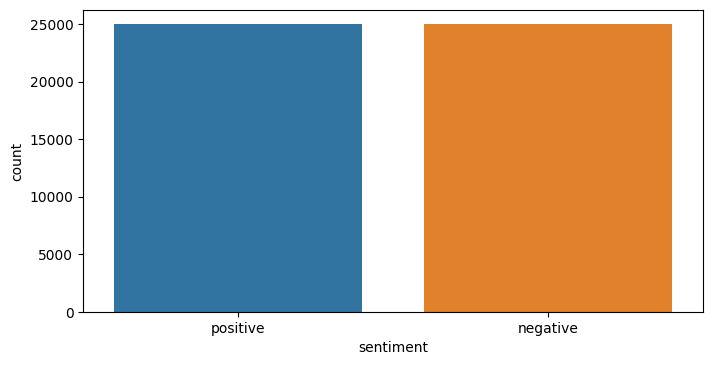

In [ ]:
df['sentiment'].value_counts()
df['sentiment'].value_counts()

plt.figure(figsize = (8,4), dpi = 100)
sns.countplot(data = df, x = 'sentiment');

In [ ]:
# 1. Negtive reviews
count_vect = CountVectorizer(stop_words = 'english')
matrix = count_vect.fit_transform(df[df.sentiment == 'negative']['review'])
freqs = zip(count_vect.get_feature_names(), matrix.sum(axis = 0).tolist()[0])
#print sorted words 
print(sorted(freqs, key = lambda x: -x[1])[:20])  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('br', 103997), ('movie', 50117), ('film', 37595), ('like', 22458), ('just', 21075), ('good', 14728), ('bad', 14726), ('time', 12358), ('really', 12355), ('don', 10622), ('story', 10185), ('people', 9469), ('make', 9355), ('movies', 8313), ('plot', 8214), ('acting', 8087), ('way', 7780), ('characters', 7353), ('watch', 7220), ('think', 7129)]


In [ ]:
# 2. Positive reviews
count_vect = CountVectorizer(stop_words = 'english')
matrix = count_vect.fit_transform(df[df.sentiment == 'positive']['review'])
freqs = zip(count_vect.get_feature_names(), matrix.sum(axis = 0).tolist()[0])
#print sorted words 
print(sorted(freqs, key = lambda x: -x[1])[:20]) 

[('br', 97954), ('film', 42110), ('movie', 37854), ('like', 17714), ('good', 15025), ('just', 14109), ('great', 12964), ('story', 12934), ('time', 12752), ('really', 10739), ('people', 8719), ('love', 8692), ('best', 8510), ('life', 8137), ('way', 7865), ('films', 7601), ('think', 7208), ('characters', 7103), ('don', 7001), ('movies', 6996)]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Preprocess Reviews

In [ ]:
# change the label from string to 0s and 1s
label={'positive':1, 'negative':0}
df['positive']=df['sentiment'].map(label)
df.head()

review sentiment  positive
0  One of the other reviewers has mentioned that ...  positive         1
1  A wonderful little production. <br /><br />The...  positive         1
2  I thought this was a wonderful way to spend ti...  positive         1
3  Basically there's a family where a little boy ...  negative         0
4  Petter Mattei's "Love in the Time of Money" is...  positive         1

### Regex

In [ ]:
# HTML Tags
df['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
# define clean function
clean_regex = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def clean(old_text):
    text = re.sub(clean_regex, '', old_text)
    return text

# apply the fuction to the entire column
df['review'] = df['review'].apply(clean)

In [ ]:
df['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
# Remove punctuation except ? and !, which represent sentiment
df.review = df.review.str.replace(r"[^\w\s\!\?]", " ")

In [ ]:
# check punctuation
df['review'][9]

'If you like original gut wrenching laughter you will like this movie  If you are young or old then you will love this movie  hell even my mom liked it Great Camp!!!'

### Remove Stopwords

In [ ]:
import nltk
nltk.download('punkt') # A popular NLTK sentence tokenizer
nltk.download('stopwords') # library of common English stopwords
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
stp=set(stopwords.words('english'))
stp.add('movie')
stp.add('film')

reviews = []
for i in df.review:
    new_words=[]
    for w in word_tokenize(i):
        if w not in stp:
            new_words.append(w)
    reviews.append(' '.join(new_words))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df.review = reviews

In [ ]:
df['review'][0]

'One reviewers mentioned watching 1 Oz episode hooked They right exactly happened The first thing struck Oz brutality unflinching scenes violence set right word GO Trust show faint hearted timid This show pulls punches regards drugs sex violence Its hardcore classic use word It called OZ nickname given Oswald Maximum Security State Penitentary It focuses mainly Emerald City experimental section prison cells glass fronts face inwards privacy high agenda Em City home many Aryans Muslims gangstas Latinos Christians Italians Irish scuffles death stares dodgy dealings shady agreements never far away I would say main appeal show due fact goes shows dare Forget pretty pictures painted mainstream audiences forget charm forget romance OZ mess around The first episode I ever saw struck nasty surreal I say I ready I watched I developed taste Oz got accustomed high levels graphic violence Not violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmat

### Stemming

In [ ]:
# import nltk
# from nltk.stem import WordNetLemmatizer
# # nltk.download('wordnet')
# from nltk.corpus import wordnet

# # lemmatization
# lemmatizer = WordNetLemmatizer()

# # source
# # https://gaurav5430.medium.com/using-nltk-for-lemmatizing-sentences-c1bfff963258

# def lemmatize_sentence(sentence):
#     #tokenize the sentence and find the POS tag for each token
#     nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
#     #tuple of (token, wordnet_tag)
#     wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
#     lemmatized_sentence = []
#     for word, tag in wordnet_tagged:
#         if tag is None:
#             #if there is no available tag, append the token as is
#             lemmatized_sentence.append(word)
#         else:        
#             #else use the tag to lemmatize the token
#             lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
#     return lemmatized_sentence

# # function to convert nltk tag to wordnet tag
# def nltk_tag_to_wordnet_tag(nltk_tag):
#     if nltk_tag.startswith('J'):
#         return wordnet.ADJ
#     elif nltk_tag.startswith('V'):
#         return wordnet.VERB
#     elif nltk_tag.startswith('N'):
#         return wordnet.NOUN
#     elif nltk_tag.startswith('R'):
#         return wordnet.ADV
#     else:          
#         return None

In [ ]:
# reviews_lemma = [' '.join(lemmatize_sentence(i)) for i in df.review]
# df['cleaned_lemmatized_reviews'] = reviews_lemma
# df.head()

In [ ]:
## perform stemming
from nltk.stem.porter import PorterStemmer

# stemming 
stemmer = PorterStemmer()
stem = []
for sent in df.review:
    sent_stem = []
    for w in word_tokenize(sent):
        w_stem = stemmer.stem(w)        
        sent_stem.append(w_stem)
    stem.append( ' '.join(sent_stem))
df['cleaned_stem_reviews'] = stem

In [ ]:
df.head()

review  ...                               cleaned_stem_reviews
0  One reviewers mentioned watching 1 Oz episode ...  ...  one review mention watch 1 Oz episod hook they...
1  A wonderful little production The filming tech...  ...  A wonder littl product the film techniqu unass...
2  I thought wonderful way spend time hot summer ...  ...  I thought wonder way spend time hot summer wee...
3  Basically family little boy Jake thinks zombie...  ...  basic famili littl boy jake think zombi closet...
4  Petter Mattei Love Time Money visually stunnin...  ...  petter mattei love time money visual stun watc...

[5 rows x 4 columns]

In [ ]:
model_results = {}

# Sentiment Prediction

## Logistic Regression


### Vectorizer

In [ ]:
# count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.3,
                                   max_features=500)

X = count_vectorizer.fit_transform(df.cleaned_stem_reviews)
y = df["positive"].values
    
df_cv = pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names())
df_cv["positive"] = y
df_cv

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


10  abl  absolut  act  action  ...  year  yet  you  young  positive
0       0    0        0    0       0  ...     0    0    0      0         1
1       0    0        0    0       0  ...     0    0    1      0         1
2       0    0        0    0       0  ...     1    0    0      1         1
3       1    0        0    0       0  ...     0    0    0      0         0
4       0    0        0    1       1  ...     0    0    0      0         1
...    ..  ...      ...  ...     ...  ...   ...  ...  ...    ...       ...
49995   1    0        0    0       0  ...     0    0    0      0         1
49996   0    0        0    1       0  ...     0    0    0      0         0
49997   0    0        0    2       0  ...     0    0    0      0         0
49998   0    0        0    0       0  ...     0    0    0      0         0
49999   0    0        0    0       0  ...     0    0    0      0         0

[50000 rows x 501 columns]

In [ ]:
# TFIDF 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),
                                   max_df=0.3,
                                   max_features=500)

X = tfidf_vectorizer.fit_transform(df.cleaned_stem_reviews)
y = df["positive"].values
    
df_tfidf = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())
df_tfidf["positive"] = y
df_tfidf

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


10  abl  absolut       act  ...  yet       you     young  positive
0      0.000000  0.0      0.0  0.000000  ...  0.0  0.000000  0.000000         1
1      0.000000  0.0      0.0  0.000000  ...  0.0  0.140115  0.000000         1
2      0.000000  0.0      0.0  0.000000  ...  0.0  0.000000  0.137926         1
3      0.143771  0.0      0.0  0.000000  ...  0.0  0.000000  0.000000         0
4      0.000000  0.0      0.0  0.072078  ...  0.0  0.000000  0.000000         1
...         ...  ...      ...       ...  ...  ...       ...       ...       ...
49995  0.125172  0.0      0.0  0.000000  ...  0.0  0.000000  0.000000         1
49996  0.000000  0.0      0.0  0.131825  ...  0.0  0.000000  0.000000         0
49997  0.000000  0.0      0.0  0.189713  ...  0.0  0.000000  0.000000         0
49998  0.000000  0.0      0.0  0.000000  ...  0.0  0.000000  0.000000         0
49999  0.000000  0.0      0.0  0.000000  ...  0.0  0.000000  0.000000         0

[50000 rows x 501 columns]

### train test split

In [ ]:
def traintest_split(df):
    from sklearn.model_selection import train_test_split
    train_df, test_df = train_test_split(df, random_state=100) # set ramdom_state for stable output
    X_train = train_df.loc[:, ~train_df.columns.isin(['positive'])]
    y_train = train_df["positive"]
    X_test = test_df.loc[:, ~test_df.columns.isin(['positive'])]
    y_test = test_df["positive"]
    
    return X_train, y_train, X_test, y_test

In [ ]:
data = df[['positive','cleaned_stem_reviews']]
X_train, y_train, X_test, y_test = traintest_split(data)

In [ ]:
len(X_train)

37500

In [ ]:
len(X_test)

12500

### Logistic Regression

In [ ]:
def lr_result(vectorized_df):
    
    X_train, y_train, X_test, y_test = traintest_split(vectorized_df)
    
    ## logistic regression 
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    # predict
    y_pred = lr.predict(X_test)
        
    ## Evaluate LR result
    # calculate accuracy
    accuracy = np.mean(y_pred == y_test)
    # AUROC (area under the receiver operator curve)
    from sklearn.metrics import roc_auc_score
    roc = roc_auc_score(y_test, y_pred) 

    return accuracy, roc, y_pred

In [ ]:
# LR using count_vectorizer
accuracy, roc, y_pred = lr_result(df_cv)
print('Accuracy: ',accuracy)
print('ROC: ',roc)
model_results['LR(count_vectorizer)'] = accuracy 

Accuracy:  0.85224
ROC:  0.8521276642317995


In [ ]:
# LR using TF-IDF vectorize
accuracy, roc, y_pred = lr_result(df_tfidf)
print('Accuracy: ',accuracy)
print('ROC: ',roc)
model_results['LR(TF-IDF)'] = accuracy

Accuracy:  0.85216
ROC:  0.8520561458697065


In [ ]:
df

review  ...                               cleaned_stem_reviews
0      One reviewers mentioned watching 1 Oz episode ...  ...  one review mention watch 1 Oz episod hook they...
1      A wonderful little production The filming tech...  ...  A wonder littl product the film techniqu unass...
2      I thought wonderful way spend time hot summer ...  ...  I thought wonder way spend time hot summer wee...
3      Basically family little boy Jake thinks zombie...  ...  basic famili littl boy jake think zombi closet...
4      Petter Mattei Love Time Money visually stunnin...  ...  petter mattei love time money visual stun watc...
...                                                  ...  ...                                                ...
49995  I thought right good job It creative original ...  ...  I thought right good job It creativ origin fir...
49996  Bad plot bad dialogue bad acting idiotic direc...  ...  bad plot bad dialogu bad act idiot direct anno...
49997  I Catholic taught parochial elementary schools...  ...  I cathol taught parochi elementari school nun ...
49998  I going disagree previous comment side Maltin ...  ...  I go disagre previou comment side maltin one t...
49999  No one expects Star Trek movies high art fans ...  ...  No one expect star trek movi high art fan expe...

[50000 rows x 4 columns]

### Logistic Regression with Spacy

In [ ]:
import spacy
import spacy.cli
spacy.cli.download("en_core_web_md")
nlp = spacy.load("en_core_web_md",disable=['ner','tagger','parser'])

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
# preprocessing review
spacy_df = pd.DataFrame(df['review'].str.replace(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', case=False))
spacy_df.columns = ['prp_review']
spacy_df.head()

prp_review
0  One reviewers mentioned watching 1 Oz episode ...
1  A wonderful little production The filming tech...
2  I thought wonderful way spend time hot summer ...
3  Basically family little boy Jake thinks zombie...
4  Petter Mattei Love Time Money visually stunnin...

In [ ]:
from string import punctuation
spacy_df['prp_lem_review'] = spacy_df['prp_review'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x) 
                                                                           if not token.is_stop 
                                                                           and token.text not in punctuation 
                                                                           and token.text!='\n']))
spacy_df.head()

prp_review                                     prp_lem_review
0  One reviewers mentioned watching 1 Oz episode ...  reviewer mention watch 1 Oz episode hook right...
1  A wonderful little production The filming tech...  wonderful little production film technique una...
2  I thought wonderful way spend time hot summer ...  think wonderful way spend time hot summer week...
3  Basically family little boy Jake thinks zombie...  Basically family little boy Jake think zombie ...
4  Petter Mattei Love Time Money visually stunnin...  Petter Mattei Love Time Money visually stun wa...

In [ ]:
spacy_df['word2vec'] = spacy_df['prp_review'].apply(lambda x: nlp(x).vector)

In [ ]:
base_df = pd.concat([pd.DataFrame(spacy_df['word2vec'].values.tolist()), df['positive'].reset_index(drop=True)], axis=1)
base_df.head()

0         1         2  ...       298       299  positive
0 -0.085625  0.113938 -0.096713  ...  0.042206  0.072123         1
1 -0.059508  0.101667 -0.066424  ... -0.007154  0.051344         1
2 -0.031895  0.128547 -0.068776  ... -0.010813  0.046681         1
3 -0.081507  0.027952 -0.144960  ... -0.033867 -0.031053         0
4 -0.013270  0.111341 -0.141966  ... -0.048905  0.064297         1

[5 rows x 301 columns]

In [ ]:
from sklearn.model_selection import cross_validate

x_train = base_df.iloc[:,:300]
y_train = base_df['positive']
lr = LogisticRegression()
score = cross_validate(lr, x_train, y_train, scoring=['accuracy','roc_auc'], cv=10, n_jobs=-1,
                           return_train_score=True, return_estimator=True)
print(np.mean(score['test_accuracy']))
print(pd.DataFrame(score['test_accuracy'],score['train_accuracy']),'\n'*2)
print(np.mean(score['test_roc_auc']))
print(pd.DataFrame(score['test_roc_auc'],score['train_roc_auc']))
model_results['LR(spacy)'] = np.mean(score['test_accuracy'])

0.8562799999999999
               0
0.857933  0.8630
0.858422  0.8626
0.859000  0.8546
0.858689  0.8578
0.859778  0.8476
0.858156  0.8638
0.860578  0.8422
0.859889  0.8524
0.858978  0.8574
0.858222  0.8614 


0.931461168
                 0
0.933289  0.935096
0.933394  0.934185
0.934099  0.927936
0.933370  0.933249
0.934729  0.921500
0.933245  0.936184
0.934191  0.927668
0.933788  0.930676
0.933421  0.934585
0.933559  0.933533


## LSTM & RNN Using Prof Chen's code

In [ ]:
import numpy as np
# NUM_SAMPLES = 3000

# good_reviews = open("../week1/good_amazon_toy_reviews.txt").readlines()
# bad_reviews = open("../week1/poor_amazon_toy_reviews.txt").readlines()

# sampled_good_reviews = good_reviews[:NUM_SAMPLES]
# sampled_bad_reviews = bad_reviews[:NUM_SAMPLES]

docs = df.review
labels = df.positive

In [ ]:
from scipy.spatial.distance import cosine
spacy.cli.download("en_core_web_lg") #takes awhile to run since I used large
nlp = spacy.load("en_core_web_lg",disable=['ner','tagger','parser'])

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
#takes very long time
stopwords_removed_docs = list(
    map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), docs))

### Tokenize Text

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(stopwords_removed_docs)

In [ ]:
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

# integer encode the documents
encoded_docs = integer_encode_documents(stopwords_removed_docs, tokenizer)

In [ ]:
seq_lengths=[len(x) for x in encoded_docs]

In [ ]:
pd.Series(seq_lengths).describe()

count    50000.000000
mean       100.933100
std         78.391106
min          3.000000
25%         52.000000
50%         74.000000
75%        123.000000
max       1298.000000
dtype: float64

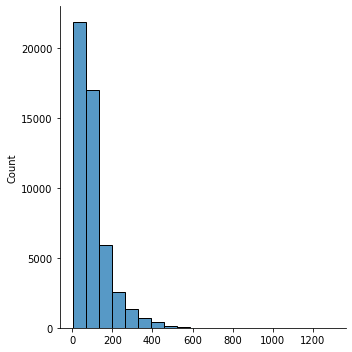

In [ ]:
sns.displot(seq_lengths,bins=20)

In [ ]:
for i in [80,90,95,99]:
  print(f"{i}th percentile of arr : ", np.percentile(seq_lengths, i))

80th percentile of arr :  141.0
90th percentile of arr :  201.0
95th percentile of arr :  266.0
99th percentile of arr :  403.0


In [ ]:
MAX_SEQUENCE_LENGTH = 150 #judging from the sequence length distribution I chose 150 for now

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


In [ ]:

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(labels))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2)

### Import Keras Toolkit

In [ ]:
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

In [ ]:
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

### Load in GloVe Vectors

In [ ]:
!wget https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
!unzip glove6b100dtxt.zip

--2021-12-18 02:27:45--  https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
Resolving dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)... 52.216.245.44
Connecting to dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)|52.216.245.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137847651 (131M) [application/zip]
Saving to: ‘glove6b100dtxt.zip.3’

glove6b100dtxt.zip. 100%[===================>] 131.46M  53.5MB/s    in 2.5s    

2021-12-18 02:27:48 (53.5 MB/s) - ‘glove6b100dtxt.zip.3’ saved [137847651/137847651]

Archive:  glove6b100dtxt.zip
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


### Load in Embeddings

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

### Define in Model

In [ ]:
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking
# define model

def make_binary_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

### Compile Model - LSTM

#### Helpful Rule of Thumb for Defining # of Parameters in LSTM:

$$
W = 4d×(n+d)
$$
Where $d$ is the number of memory cells, and $N$ is the number of dimensions for a data point.

In [ ]:
model = make_lstm_classification_model()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          11384500  
                                                                 
 masking_1 (Masking)         (None, 150, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 11,402,086
Trainable params: 17,586
Non-trainable params: 11,384,500
_________________________________________________________________


### Fit the Model

In [ ]:
from keras import callbacks
callback = callbacks.EarlyStopping(monitor='val_loss', patience=2)
# fit the model
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=20, verbose=1, callbacks=[callback])

Epoch 1/20
1125/1125 [==============================] - 128s 112ms/step - loss: 0.4361 - accuracy: 0.7959 - val_loss: 0.3692 - val_accuracy: 0.8340
Epoch 2/20
1125/1125 [==============================] - 126s 112ms/step - loss: 0.3342 - accuracy: 0.8547 - val_loss: 0.3817 - val_accuracy: 0.8365
Epoch 3/20
1125/1125 [==============================] - 119s 106ms/step - loss: 0.3007 - accuracy: 0.8704 - val_loss: 0.3113 - val_accuracy: 0.8627
Epoch 4/20
1125/1125 [==============================] - 118s 105ms/step - loss: 0.2787 - accuracy: 0.8822 - val_loss: 0.3186 - val_accuracy: 0.8680
Epoch 5/20
1125/1125 [==============================] - 119s 105ms/step - loss: 0.2588 - accuracy: 0.8919 - val_loss: 0.3068 - val_accuracy: 0.8720
Epoch 6/20
1125/1125 [==============================] - 118s 105ms/step - loss: 0.2439 - accuracy: 0.8994 - val_loss: 0.2954 - val_accuracy: 0.8780
Epoch 7/20
1125/1125 [==============================] - 118s 105ms/step - loss: 0.2275 - accuracy: 0.9069 - val_

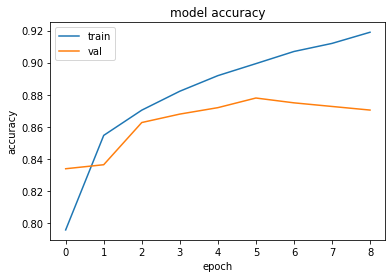

In [ ]:
import keras
from matplotlib import pyplot as plt

def plot_fit_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_fit_history(history)

### Evaluate the Model

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))
model_results['LSTM'] = accuracy

313/313 [==============================] - 10s 29ms/step - loss: 0.3360 - accuracy: 0.8739
Accuracy: 87.390000


### Compile Model - RNN

#### Helpful Rule of Thumb for Defining # of Parameters in LSTM:

$$
W = 4d×(n+d)
$$
Where $d$ is the number of memory cells, and $N$ is the number of dimensions for a data point.

In [ ]:
model = make_binary_classification_rnn_model()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 100)          11384500  
                                                                 
 masking_2 (Masking)         (None, 150, 100)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 11,396,134
Trainable params: 11,634
Non-trainable params: 11,384,500
_________________________________________________________________


### Fit the Model

In [ ]:
from keras import callbacks
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
# fit the model
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=20, verbose=1, callbacks=[callback])

Epoch 1/20
1125/1125 [==============================] - 61s 54ms/step - loss: 0.6334 - accuracy: 0.6464 - val_loss: 0.5531 - val_accuracy: 0.7340
Epoch 2/20
1125/1125 [==============================] - 53s 47ms/step - loss: 0.6189 - accuracy: 0.6541 - val_loss: 0.6229 - val_accuracy: 0.6425
Epoch 3/20
1125/1125 [==============================] - 54s 48ms/step - loss: 0.5939 - accuracy: 0.6809 - val_loss: 0.5731 - val_accuracy: 0.7125
Epoch 4/20
1125/1125 [==============================] - 53s 47ms/step - loss: 0.5586 - accuracy: 0.7166 - val_loss: 0.4907 - val_accuracy: 0.7715
Epoch 5/20
1125/1125 [==============================] - 54s 48ms/step - loss: 0.5969 - accuracy: 0.6830 - val_loss: 0.6505 - val_accuracy: 0.6180
Epoch 6/20
1125/1125 [==============================] - 52s 47ms/step - loss: 0.5798 - accuracy: 0.6982 - val_loss: 0.5427 - val_accuracy: 0.7337
Epoch 7/20
1125/1125 [==============================] - 52s 47ms/step - loss: 0.6021 - accuracy: 0.6785 - val_loss: 0.6116 -

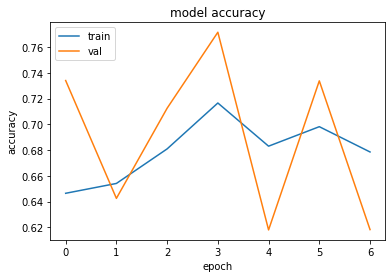

In [ ]:
import keras
from matplotlib import pyplot as plt

def plot_fit_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_fit_history(history)

### Evaluate the Model

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))
model_results['RNN'] = accuracy

313/313 [==============================] - 6s 18ms/step - loss: 0.6173 - accuracy: 0.6121
Accuracy: 61.210001


### Try Some Random Reviews

In [ ]:
# test_docs = [
#     "Amazing, my son loved it as soon as he opened it.",
#     "Piece of crap junk broke as soon as it was opened.",
#     "Solid toy, it was easy to set up and still works even years later"
# ]

# test_docs = list(
#     map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), test_docs))

# encoded_test_sample = integer_encode_documents(test_docs, tokenizer)

# padded_test_docs = pad_sequences(encoded_test_sample, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# prediction = model.predict_classes(padded_test_docs)
# encoder.inverse_transform(prediction)

## Sentiment Prediction with Hugging Face

In [ ]:
!pip install transformers
!pip install sentence-transformers

     |████████████████████████████████| 3.4 MB 31.0 MB/s 
     |████████████████████████████████| 61 kB 433 kB/s 
     |████████████████████████████████| 596 kB 38.3 MB/s 
     |████████████████████████████████| 3.3 MB 38.5 MB/s 
     |████████████████████████████████| 895 kB 56.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 78 kB 6.9 MB/s 
     |████████████████████████████████| 1.2 MB 40.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=7befd60af352afb4f2039967d356ada5be1073ff0358d1b787a407c8f1147b34
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers


In [ ]:
from transformers import pipeline
# from transformers import BertTokenizer
from transformers import BertTokenizerFast
classifier = pipeline('sentiment-analysis')
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased', do_lower_case=False)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Prediction with Raw Text

In [ ]:
classifier(df['review'][0])

[{'label': 'NEGATIVE', 'score': 0.9896913170814514}]

In [ ]:
tokenizer.decode(tokenizer.encode(df['review'][0], padding=True, truncation=True,max_length=500, add_special_tokens = True))

'[CLS] One reviewers mentioned watching 1 Oz episode hooked They right exactly happened The first thing struck Oz brutality unflinching scenes violence set right word GO Trust show faint hearted timid This show pulls punches regards drugs sex violence Its hardcore classic use word It called OZ nickname given Oswald Maximum Security State Penitentary It focuses mainly Emerald City experimental section prison cells glass fronts face inwards privacy high agenda Em City home many Aryans Muslims gangstas Latinos Christians Italians Irish scuffles death stares dodgy dealings shady agreements never far away I would say main appeal show due fact goes shows dare Forget pretty pictures painted mainstream audiences forget charm forget romance OZ mess around The first episode I ever saw struck nasty surreal I say I ready I watched I developed taste Oz got accustomed high levels graphic violence Not violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class

In [ ]:
# Since classifier specifies maximum sequence length which is 512, we have to cut sequence length 
def cut_review(x):
    return tokenizer.decode(tokenizer.encode(x, padding=True, truncation=True, max_length=500, add_special_tokens = True))
    
raw_review_cut = spacy_df.apply(lambda x: cut_review(x['prp_review']), axis=1) 

In [ ]:
# Sincer bert is kind of slow, we pridict first 1000 reviews as an example
raw_review_prd = raw_review_cut[:1000].apply(lambda x: classifier(x)[0]['label']).map({'POSITIVE':1, 'NEGATIVE':0})

In [ ]:
print('Accuracy with raw text: ', (df['positive'][:1000] == raw_review_prd).mean())
model_results['HuggingFace'] = (df['positive'][:1000] == raw_review_prd).mean()

Accuracy with raw text:  0.82


### Prediction with Summerization

In [ ]:
# summarizer = pipeline("summarization")

In [ ]:
# # Summerization took a lot of time and could not increase accuracy significantly 
# summerization_review = spacy_df['prp_review'][:100].apply(lambda x: summarizer(x, max_length=500, do_sample=False)[0]['summary_text'])
# summerization_review_cut = summerization_review.apply(lambda x: cut_review(x))
# summerization_review_prd = summerization_review_cut.apply(lambda x: classifier(x)[0]['label']).map({'POSITIVE':1, 'NEGATIVE':0})
# print('Accuracy with raw text: ', (df['positive'][:100] == summerization_review_prd).mean())

The output would be

Accuracy with raw text:  0.82

## Results for all model built

In [ ]:
pd.DataFrame(model_results, index=['Accuracy']).T

Accuracy
LR(count_vectorizer)   0.85224
LR(TF-IDF)             0.85216
LR(spacy)              0.85628
LSTM                   0.87390
RNN                    0.61210
HuggingFace            0.82000

# Topic Modeling

In [ ]:
# add more stopwords
# We add some new stopwords including some verbs, adverbs 
# and words about sentiment to better analyze topics of the movies
new_stp=stp
to_add=["worst","bad","good", "better", "like", "just","really", "great", "best", "ever", "seen", "waste",
       "wast", "time", "money", "see", "saw", "well", "worth", "recommond", "blah", "anyon", "year", "old",
       "even", "though", "although", "charact", "main", "theater", "hour", "minute", "watch", "minut",
        "never", "make", "take", "would", "highly", "video"]
for w in new_stp:
    w_stem = stemmer.stem(w) 
    if w_stem!=w and w_stem not in new_stp:
        to_add.append(w_stem)
for t in to_add:
    new_stp.add(t)

In [ ]:
# define function for regex cleaning
def replace_x(x, y, text):
    for i in range(0, len(text)):
        text[i]=re.sub(x, y,text[i], flags=re.IGNORECASE)
    return text
    
# remove numbers
df["cleaned_stem_reviews"]=replace_x(r"\d+", '', df["cleaned_stem_reviews"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Vectorize The Corpus

In [ ]:
# We tried ngram=2 and ngram=3 and we found ngram=3 was more meaningful.
# Although infrequent words are useful for us to analyze the texts, 
# they may be less useful in topic modeling because we want to find topics in common. 
# min_df=10 can help us get rid of those words and lower dimensions.
# max_df=0.4 help us get rid of common words appear in too many documents and topics.

from sklearn.decomposition import NMF

vectorizer = TfidfVectorizer(ngram_range=(3,3), 
                             min_df = 10, max_df=0.4, stop_words=new_stp)

X_reviews, reviews_terms = vectorizer.fit_transform(df["cleaned_stem_reviews"]), vectorizer.get_feature_names()
reviews_tf_idf = pd.DataFrame(X_reviews.toarray(), columns=reviews_terms)

print(f"Reviews TF-IDF: {reviews_tf_idf.shape}")
reviews_tf_idf.head(5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Reviews TF-IDF: (50000, 2011)


abbott costello meet  absolut noth els  ...  young mr lincoln  young woman name
0                   0.0               0.0  ...               0.0               0.0
1                   0.0               0.0  ...               0.0               0.0
2                   0.0               0.0  ...               0.0               0.0
3                   0.0               0.0  ...               0.0               0.0
4                   0.0               0.0  ...               0.0               0.0

[5 rows x 2011 columns]

## Fit NMF Model

In [ ]:
nmf = NMF(n_components=5)
W_reviews = nmf.fit_transform(X_reviews)
H_reviews = nmf.components_
print(f"Original shape of X sports is {X_reviews.shape}")
print(f"Decomposed W sports matrix is {W_reviews.shape}")
print(f"Decomposed H sports matrix is {H_reviews.shape}")

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Original shape of X sports is (50000, 2011)
Decomposed W sports matrix is (50000, 5)
Decomposed H sports matrix is (5, 2011)


## Report Results For Each Topic

In [ ]:
from typing import List
import numpy as np

def get_top_tf_idf_tokens_for_topic(H: np.array, feature_names: List[str], num_top_tokens: int = 5):
  """
  Uses the H matrix (K components x M original features) to identify for each
  topic the most frequent tokens.
  """
  for topic, vector in enumerate(H):
    print(f"TOPIC {topic}\n")
    total = vector.sum()
    top_scores = vector.argsort()[::-1][:num_top_tokens]
    token_names = list(map(lambda idx: feature_names[idx], top_scores))
    strengths = list(map(lambda idx: vector[idx] / total, top_scores))
    
    for strength, token_name in zip(strengths, token_names):
      print(f"\b{token_name} ({round(strength * 100, 1)}%)\n")
    print(f"=" * 50)

print(f"Movie Reviews Topics:\n\n")
get_top_tf_idf_tokens_for_topic(H_reviews, reviews_tf_idf.columns.tolist(), 5)

Movie Reviews Topics:


TOPIC 0

new york citi (59.2%)

live new york (1.8%)

street new york (1.6%)

set new york (1.0%)

citi new york (1.0%)

TOPIC 1

world war ii (64.0%)

post world war (1.9%)

save privat ryan (1.3%)

kristin scott thoma (1.3%)

sit back enjoy (0.8%)

TOPIC 2

base true stori (69.4%)

stori base true (1.1%)

real life stori (0.7%)

top notch perform (0.6%)

dream come true (0.6%)

TOPIC 3

sci fi channel (53.0%)

fi channel origin (3.2%)

john rhi davi (1.8%)

made sci fi (1.7%)

horror sci fi (1.7%)

TOPIC 4

texa chainsaw massacr (22.4%)

low budget horror (12.7%)

blair witch project (7.5%)

night live dead (2.7%)

budget horror flick (1.8%)



## Get the Top Documents For Each Topic

In [ ]:
def get_top_documents_for_each_topic(W: np.array, documents: List[str], num_docs: int = 5):
  sorted_docs = W.argsort(axis=0)[::-1]
  top_docs = sorted_docs[:num_docs].T
  per_document_totals = W.sum(axis=1)
  for topic, top_documents_for_topic in enumerate(top_docs):
    print(f"Topic {topic}")
    for doc in top_documents_for_topic:
      score = W[doc][topic]
      percent_about_topic = round(score / per_document_totals[doc] * 100, 1)
      print(f"{percent_about_topic}%", documents[doc])
    print("=" * 50)

In [ ]:
get_top_documents_for_each_topic(W_reviews, df.review.tolist(), num_docs=5)

Topic 0
100.0% I fan Adam Sandler In fact I think I ever liked anything I seen The opening scene confirmed worst fears There Adam Sandler playing somewhat ridiculous looking character riding around New York City motor scooter looking pitiful lost Typical Sandler type loser character I thought I almost gave But I stuck I actually discovered something I never knew Adam Sandler act ! He truly outstanding Charlie lost lonely figure whose entire family including dog killed one hijacked planes 9 11 apparently lost touch reality result Don Cheadle plays former college roommate unexpectedly reconnects Charlie takes mission help get better Of course Cheadle Alan Johnson problems sources unhappiness somehow two men manage help difficulties The two made completely believable team Sandler particular made Charlie real working emotions feelings This Sandler comedy If looking go sillier stuff This pretty heavy sometimes sad sometimes hopeful always engrossing There funny parts I loved scene Charlie c

## WordCloud for Each Topic

In [ ]:
H_reviews_df = pd.DataFrame(H_reviews, columns=reviews_tf_idf.columns)
H_reviews_df

abbott costello meet  absolut noth els  ...  young mr lincoln  young woman name
0          8.011597e-06          0.000050  ...      2.534314e-07          0.006519
1          1.632779e-04          0.000000  ...      2.342776e-05          0.000000
2          4.935266e-07          0.000081  ...      4.708371e-05          0.007109
3          6.740880e-05          0.000040  ...      2.004045e-06          0.000074
4          4.224777e-04          0.015056  ...      1.295810e-04          0.000785

[5 rows x 2011 columns]

In [ ]:
occurence = []
for i in range(len(H_reviews_df)):
    occurence.append(H_reviews_df.loc[i,:].to_dict())

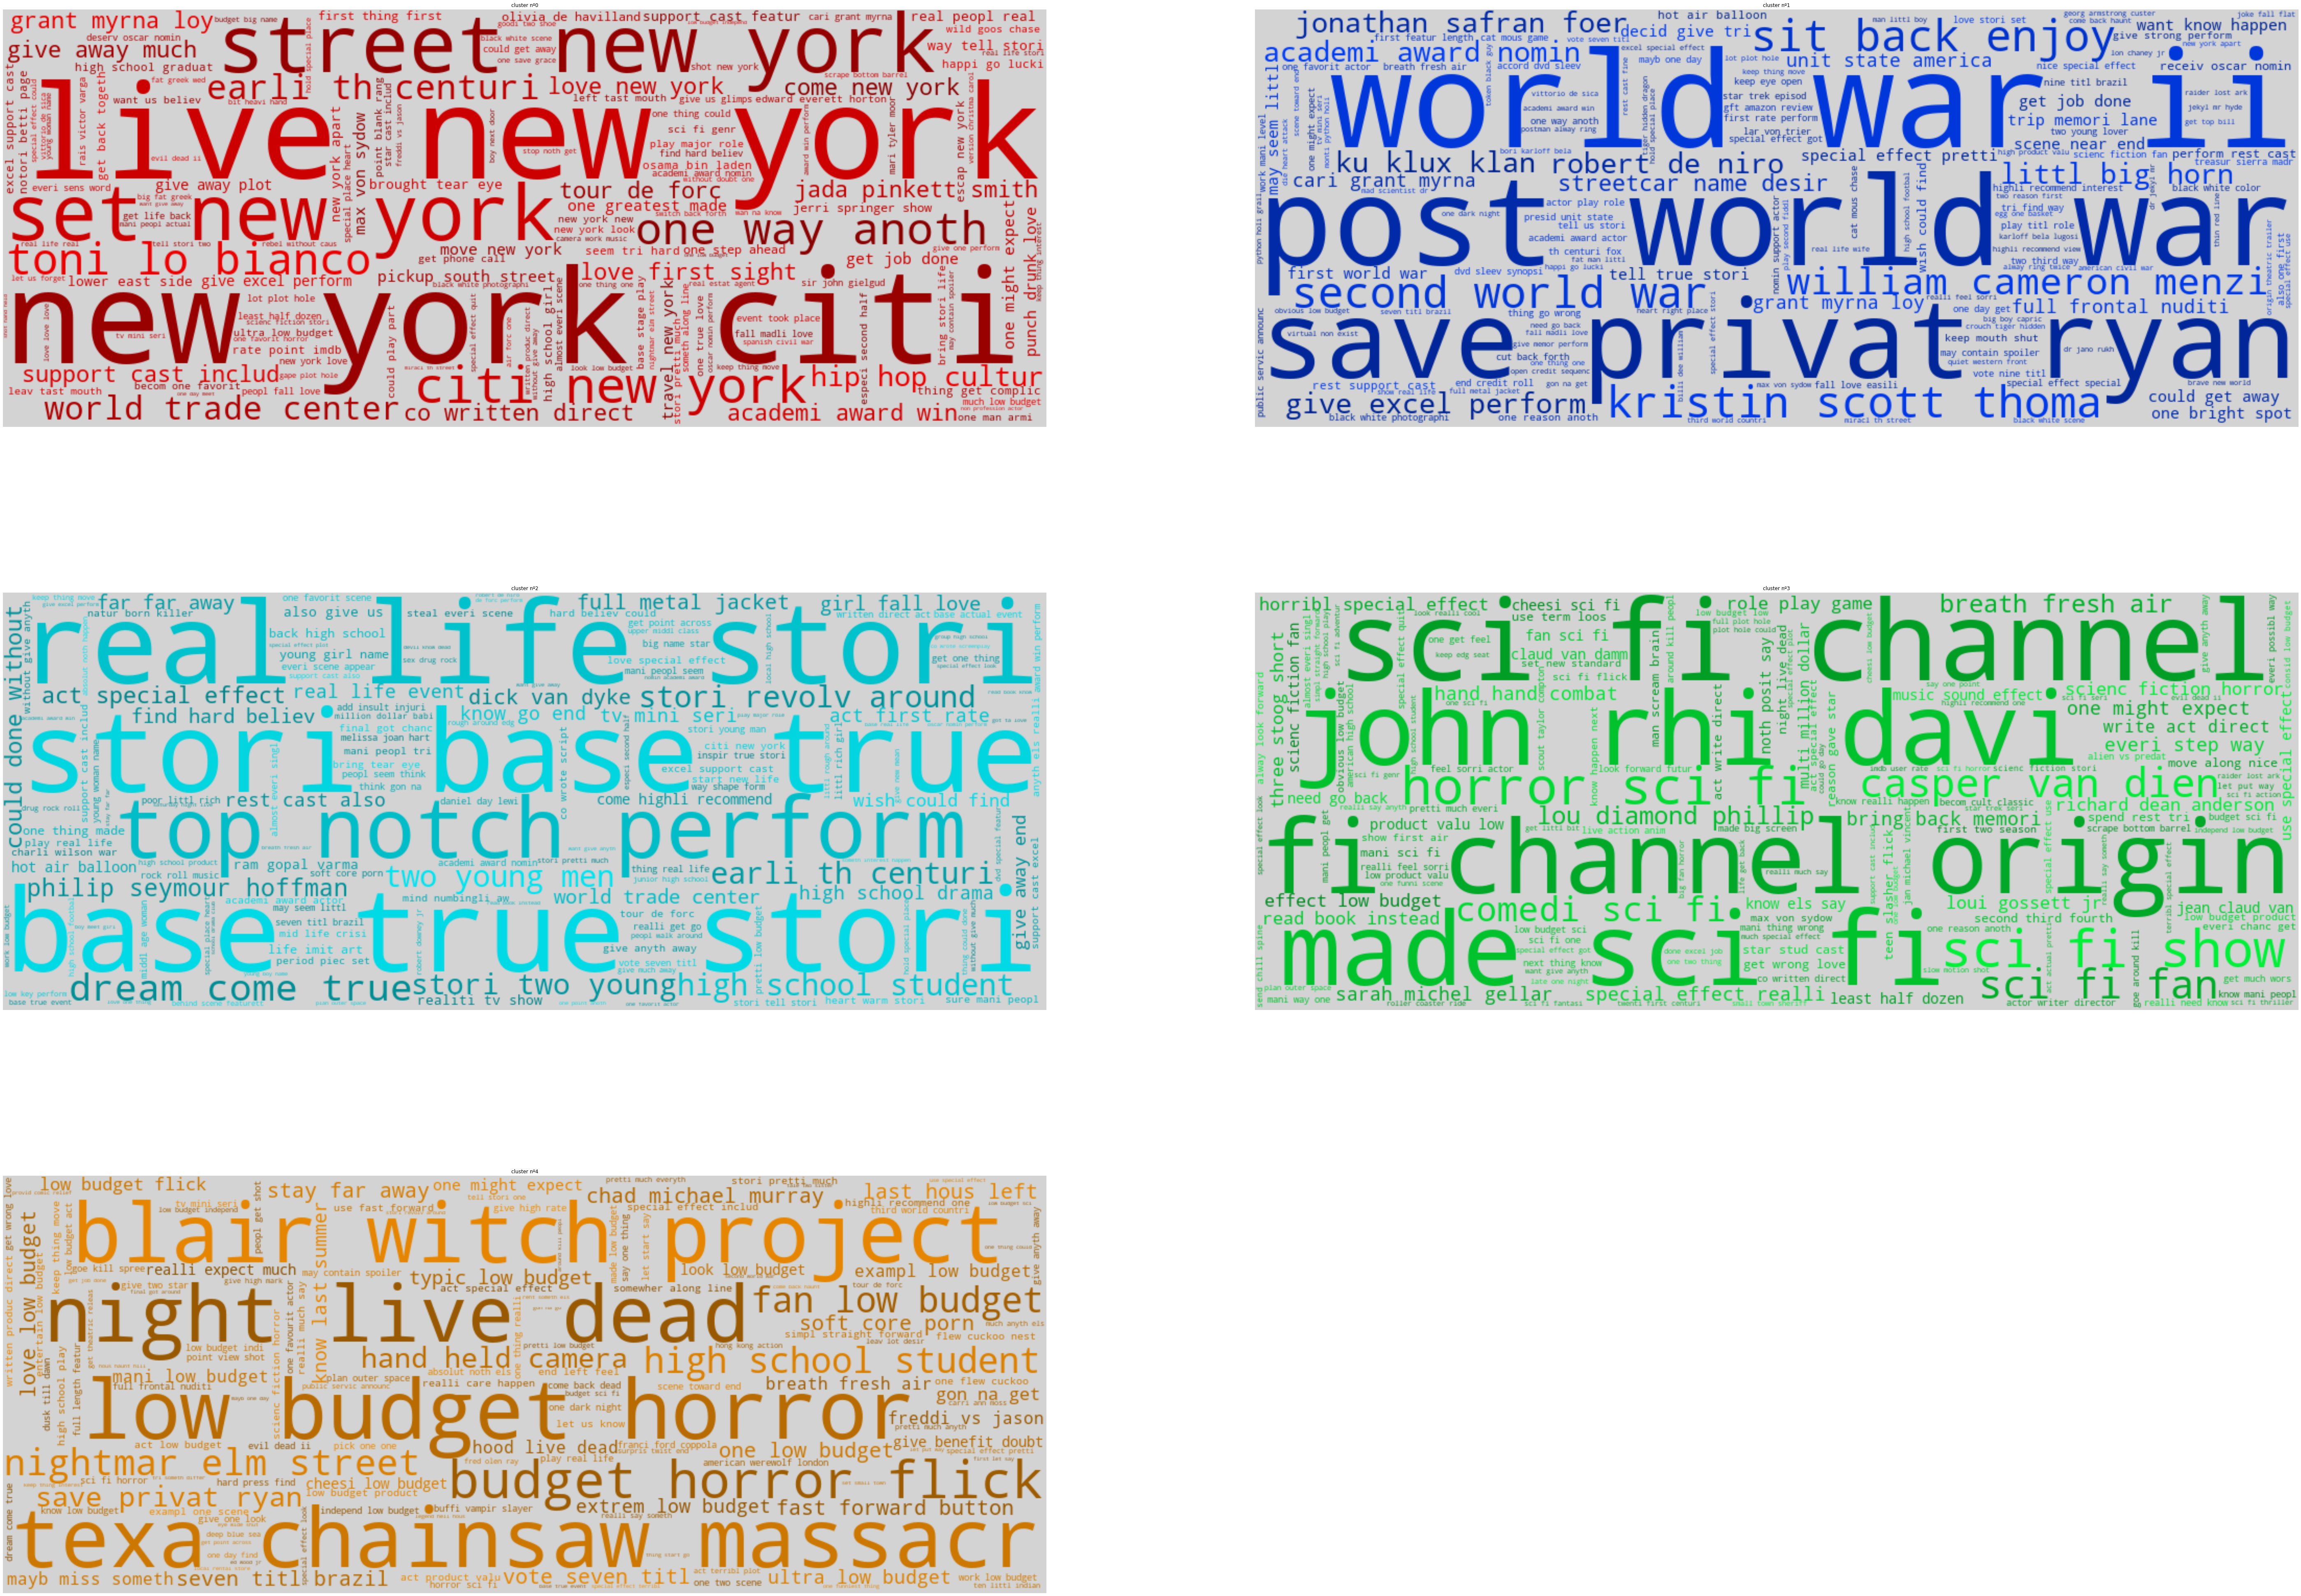

In [ ]:
# This snippet creating wordcloud comes from my HW of DSO528

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=0,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(100,100))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
n_clusters = 5
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)    

We can see from wordcloud above, there are 5 topics in the review dataset. 
- Topic0: This topic is about New York city, we can also find something like “World Trade Center” that are related to NYC
- Topic1: These reviews are from some war films, as we can see some key words like 'Word War ii', and 'Saving Private Ryan' which is one of my favorite movies.
- Topic2: This topic is about some Biographies and inspirational movies, as we can find some like 'true story' and 'dream com true'.
- Topic3: This topic is about some fiction, especially science fiction. Besides, we can also find the name of a Welsh actor John Rhys-Davies, who is best known for The Lord of the Rings.
- Topic4: The last topic is obviously about horror fiction, we can see some key words like 'low budget horro', 'blair witch' and 'Texa Chainsaw Massacre' which is a famous American horror franchise.